# Experiment 2: Document at various level for small dataset(COVID-science:non-science)

## 1. Article level

In the file each article is seperated by 'NEW_PAPER' in 'covid-scienc.txt' and 'NEW NEWSPAPER' in 
'covid-non-science'.

In [1]:
#importing libraries
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as s
import dataframe_image as dfi
import networkx as nx
import mantel

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### LSA on covid-science-small.txt at article level

In [2]:
def load_data(path,file_name,seperator):
    """
    Input  : path and file_name
    function: loading text file
    Output : number of words, document list
    """
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r", encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            i=i+1
            if text !='':
                document = document+text
                if text == seperator:
                    documents_list.append(document)
                    document = ''
        documents_list.append(document)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [3]:
document_list,titles,word_count_science=load_data("","covid-science-small.txt",'NEW_PAPER')

Number of words in text file : 59691
Total Number of Documents: 10


In [4]:
def preprocess_data(doc_set):
    """
    Input  : list of documents
    function: text preprocessing - word tokenize, removing english stopwords, and potter stemming 
    Output : clean text
    """
    # initialize regex tokenizer
    word_tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    eng_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    po_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = word_tokenizer.tokenize(raw)
        tokens = [i for i in tokens if len(i)>3]
        print(tokens)
        # removing english stop words from tokens
        stopped_tokens = [i for i in tokens if not i in eng_stop]
        # stemmed tokens
        stem_tokens = [po_stemmer.stem(i) for i in stopped_tokens]
        # list of tokens
        texts.append(stem_tokens)
    return texts

In [5]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnetmethodology', 'predicting', 'covid', '19based', 'chest', 'imagess', 'tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herreraabstract', 'currently', 'coronavirus', 'disease', 'covid', 'most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans', 'orchest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'mostmedical', 'centers', 'hence', 'many', 'cases', 'imagesbecome', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networkshave', 'great', 'potential', 'building', 'covid', 'triage', 'systemsand', 'detecting', 'covid', 'patients', 'especially', 'patients', 'withlow', 'severity', 'unfortunately', 'current', 'databases', 'allowbuilding', 'such', 'systems', 'they', 'highly', 'heterog

In [6]:
# preparing corpus for LSA
def prepare_corpus(doc_clean):
    """
    Input  : preprossed document
    function: creating term dictionary and document term matrix
    Output : term dictionary and Document Term Matrix
    """
    # every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    term_dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    docu_term_matrix = [term_dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return term_dictionary,docu_term_matrix

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : preprocessed document, number of topics and word count
    function: create LSA model using gensim
    Output : return LSA model
    """
    term_dictionary,docu_term_matrix=prepare_corpus(doc_clean)
    # LSA model
    lsamodel = LsiModel(docu_term_matrix, num_topics=number_of_topics, id2word = term_dictionary)  # train model
    return lsamodel

In [8]:
# LSA Model
number_of_topics=10
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_covid_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [9]:
#dictionary of top 5 words
dict(model_science.show_topic(0, topn=5))

{'covid': 0.43749904050277927,
 'model': 0.3134819868536473,
 'imag': 0.30230356131240915,
 'use': 0.2098856921185124,
 'class': 0.1904748020650815}

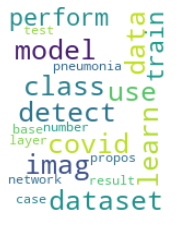

In [10]:
#wordcloud API
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph6.png')

In [11]:
# Generating Cosine_similarity matrix for top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_covid_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_covid_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled6.png')

cosine-similarity
          covid      model      imag       use      class
covid         1   0.242425  0.552974  0.415864   0.726722
model  0.242425          1  -0.24754  0.116798 -0.0427932
imag   0.552974   -0.24754         1  0.484501   0.444943
use    0.415864   0.116798  0.484501         1   0.239286
class  0.726722 -0.0427932  0.444943  0.239286          1


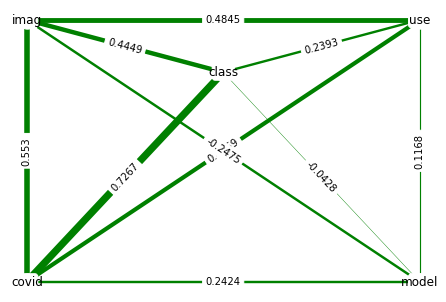

In [12]:
# Generating NetworkX graph for top 5 words from the corpus

df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig6.png')

### LSA on covid-non-science-small.txt at article level

In [13]:
#loading covid non science dataset
document_list,titles,word_count_nscience=load_data("","covid-non-science-small.txt",'NEW NEWSPAPER')

Number of words in text file : 5231
Total Number of Documents: 10


In [14]:
#data preprocessing
clean_text=preprocess_data(document_list)

['covid', 'recovery', 'covid', 'realityby', 'reuterspublished', 'july', '2020', 'updated', 'july', '2020by', 'marc', 'joneslondon', 'july', 'reuters', 'world', 'shares', 'inched', 'towards', 'four', 'month', 'high', 'friday', 'industrial', 'bellwether', 'metal', 'copper', 'longest', 'weekly', 'winning', 'streak', 'nearly', 'three', 'years', 'recovering', 'global', 'data', 'kept', 'nagging', 'coronavirus', 'nerves', 'market', 'rally', 'fuelled', 'record', 'jobs', 'numbers', 'largely', 'blown', 'itself', 'amid', 'spike', 'covid', 'cases', 'though', 'fastest', 'expansion', 'china', 'services', 'sector', 'over', 'decade', 'more', 'stimulus', 'ensured', 'optimism', 'remained', 'chinese', 'shares', 'charged', 'their', 'highest', 'level', 'five', 'years', 'helping', 'asian', 'indexes', 'month', 'peaks', 'sight', 'european', 'markets', 'stalling', 'early', 'took', 'some', 'traders', 'surprise', 'currency', 'commodity', 'markets', 'also', 'subdued', 'feel', 'after', 'otherwise', 'strong', 'week

In [15]:
# LSA Model
number_of_topics=10
words=word_count_nscience
model_nscience=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_non_science =dict(model_nscience.show_topic(0, topn=words))#dict and encoding matrix values


In [16]:
# generated top 5 words using lSA
dict(model_nscience.show_topic(0,topn=5))

{'test': 0.5996895875834207,
 'peopl': 0.2882010064110186,
 'covid': 0.23768902176777906,
 'symptom': 0.21329725997683804,
 'case': 0.19112113436138517}

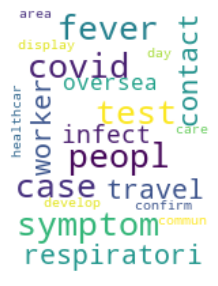

In [17]:
#wordcloud API
from wordcloud import WordCloud
text = dict(model_nscience.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph7.png')

In [18]:
# Cosine similarity matrix for top 5 words from corpus

a=pd.DataFrame()

for i in range(number_of_topics):
    words_covid_non_science =dict(model_nscience.show_topic(i, topn=words))
    b=pd.DataFrame(words_covid_non_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_nscience.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled7.png')

cosine-similarity
             test     peopl      covid    symptom      case
test            1  0.833309   0.286923   0.911199  0.356577
peopl    0.833309         1   0.226664   0.919123   0.19254
covid    0.286923  0.226664          1  0.0492026  0.370479
symptom  0.911199  0.919123  0.0492026          1  0.273434
case     0.356577   0.19254   0.370479   0.273434         1


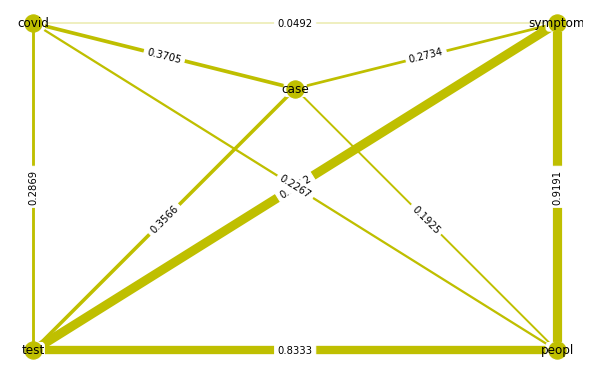

In [19]:
#Generated Networkx for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='y',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="y")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig7.png')

### LSA on covid-psychology-small.txt at article level

In [20]:
#loading covid psychology small dataset
document_list,titles,word_count_psy=load_data("","covid-psychology-SMALL.txt",'NEW PAPER')

Number of words in text file : 39735
Total Number of Documents: 10


In [21]:
#data preprocessing/cleaning
clean_text=preprocess_data(document_list)

['international', 'sociology2021', 'author', '2020article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissionsdoi', '1177', '0268580920948807journals', 'sagepub', 'home', 'isspsychology', 'politics', 'ofcovid', 'misinfodemics', 'peoplebelieve', 'misinfodemics', 'sonia', 'mukhtaruniversity', 'management', 'technology', 'lahore', 'pakistanabstractmisinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adversehealth', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicateevidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects', 'ofmisinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevierabout', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'reviewed', 'this', 'article', 'thisreview', 'examin

In [22]:
# LSA Model
number_of_topics=10
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))#dict and encoding matrix values


In [23]:
#top 5 words generated from psychology dataset
dict(model_psy.show_topic(0,topn=5))

{'2020': 0.4097549480231352,
 'covid': 0.37354491310215926,
 'psycholog': 0.2500233429332007,
 'pandem': 0.21749252372444458,
 'impact': 0.1958265527003977}

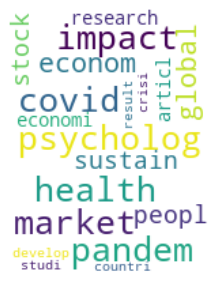

In [24]:
#wordcloud for top 10 words
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph27.png')

In [25]:
# Cosine similarity matrix for top 5 words
a=pd.DataFrame()

for i in range(number_of_topics):
    words_psychology =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psychology,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled8.png')

cosine-similarity
               2020     covid psycholog    pandem    impact
2020              1  0.553352   0.15666  0.725075  0.507801
covid      0.553352         1  0.538492  0.428987  0.545456
psycholog   0.15666  0.538492         1  0.418044  0.297771
pandem     0.725075  0.428987  0.418044         1  0.645128
impact     0.507801  0.545456  0.297771  0.645128         1


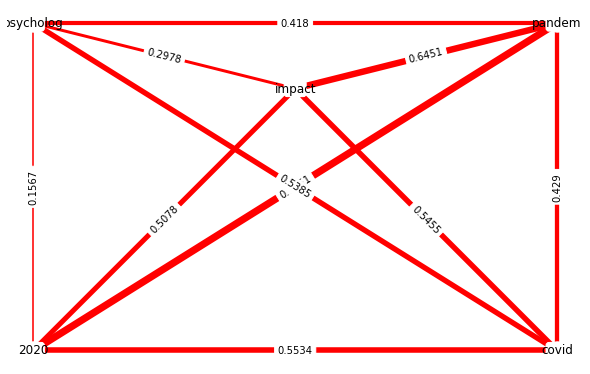

In [26]:
#generating networkx graph for top 5 words 
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig8.png')

In [27]:
# defining mantel test function
def mantel_test(n):
    #all words from corpus
    words_science = dict(model_science.show_topic(0, topn=word_count_science))
    words_psy = dict(model_psy.show_topic(0, topn=word_count_psy))
    
    #top words from the corpus
    top_words_science = dict(model_science.show_topic(0, topn=n)) 
    top_words_psy = dict(model_psy.show_topic(0,topn=n)) 

    #Finding out the weights of top 5 law words in covid science and updating their weights w.r.t psychology dataset 
    c={} 
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)

    #Finding out the weights of top 5 law words in covid psychology and updating their weights w.r.t covid science dataset 
    b={} 
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for top 10 words in covid science
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_science.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace of top 10 words in psychology dataset
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_psy.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=100000, method='pearson', tail='upper')

In [28]:
#mantel test with 10 word network
mantel_test(5)

Pairwise-distance
               2020     covid    psycholog    pandem     impact     model  \
2020              0  0.534783     0.305609  0.363047   0.310612  0.635014   
covid      0.534783         0     0.483042  0.494405   0.463392  0.703598   
psycholog  0.305609  0.483042  8.23181e-11  0.161631  0.0565689  0.642125   
pandem     0.363047  0.494405     0.161631         0   0.186003  0.646317   
impact     0.310612  0.463392    0.0565689  0.186003          0  0.649139   
model      0.635014  0.703598     0.642125  0.646317   0.649139         0   
imag       0.658395  0.487238     0.541685  0.587713   0.545382  0.936326   
use        0.321917  0.464427     0.349711  0.377897   0.349062  0.694206   
class      0.447607  0.333658     0.383029  0.462755   0.367729  0.761075   

               imag          use     class  
2020       0.658395     0.321917  0.447607  
covid      0.487238     0.464427  0.333658  
psycholog  0.541685     0.349711  0.383029  
pandem     0.587713     0.37789

(-0.3228753417554325, 0.88872, -1.1434671968358807)

In [29]:
#mantel test with 20 word network
mantel_test(10)

Pairwise-distance
               2020     covid    psycholog    pandem     impact     health  \
2020              0  0.534783     0.305609  0.363047   0.310612   0.308508   
covid      0.534783         0     0.483042  0.494405   0.463392   0.455973   
psycholog  0.305609  0.483042  8.23181e-11  0.161631  0.0565689  0.0726313   
pandem     0.363047  0.494405     0.161631         0   0.186003   0.147486   
impact     0.310612  0.463392    0.0565689  0.186003          0  0.0614011   
health     0.308508  0.455973    0.0726313  0.147486  0.0614011          0   
market     0.298177  0.484587    0.0140432  0.160027  0.0635518  0.0768204   
econom     0.308531  0.479701    0.0157494  0.151438  0.0621237  0.0696727   
global     0.333443  0.486064    0.0770943  0.110073   0.111356   0.085622   
sustain    0.307778   0.48355    0.0104329  0.153619  0.0628686  0.0733919   
model      0.635014  0.703598     0.642125  0.646317   0.649139   0.637645   
imag       0.658395  0.487238     0.541685  0.

(-0.26948036532583, 0.92241, -1.3543149889229291)

In [30]:
# mantel test for covid science and non science dataset(Not necessary for experimental results of project)
def mantel_test_n(n):
    words_science = dict(model_science.show_topic(0, topn=word_count_science))
    words_nscience = dict(model_nscience.show_topic(0, topn=word_count_nscience))

    top_words_science = dict(model_science.show_topic(0, topn=n)) 
    top_words_nscience = dict(model_nscience.show_topic(0,topn=n)) 


    c={} 
    for key in top_words_science:
        try:
            c[key] = words_nscience[key]
        except KeyError:
            c[key] = 0

    top_words_nscience.update(c)

    b={} 
    for key in top_words_nscience:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance 
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_science.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace 
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_nscience =dict(model_nscience.show_topic(i, topn=word_count_nscience))
        b=pd.DataFrame(words_from_nscience,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_nscience.keys()), 
                      index = list(top_words_nscience.keys()))

    l = list(top_words_nscience.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_nscience), k = 1)])

    return mantel.test(dist1, dist2, perms=100000, method='pearson', tail='upper')

In [31]:
mantel_test_n(5)

Pairwise-distance
             test        peopl     covid   symptom      case     model  \
test            0     0.347187  0.598824  0.490315  0.708188  0.817206   
peopl    0.347187  2.63418e-09  0.495797  0.170185  0.478369  0.674606   
covid    0.598824     0.495797         0   0.48347  0.647243  0.703598   
symptom  0.490315     0.170185   0.48347         0  0.462958  0.642135   
case     0.708188     0.478369  0.647243  0.462958         0  0.703596   
model    0.817206     0.674606  0.703598  0.642135  0.703596         0   
imag     0.738193     0.617784  0.487238  0.542373   0.76704  0.936326   
use      0.599348      0.38579  0.464427  0.341378  0.423972  0.694206   
class    0.644169     0.434128  0.333658  0.379857  0.591853  0.761075   

             imag          use     class  
test     0.738193     0.599348  0.644169  
peopl    0.617784      0.38579  0.434128  
covid    0.487238     0.464427  0.333658  
symptom  0.542373     0.341378  0.379857  
case      0.76704     0.42

(0.04021584263963283, 0.45563, 0.14217850358220085)

In [32]:
mantel_test_n(10)

Pairwise-distance
                 test        peopl     covid    symptom      case      fever  \
test                0     0.347187  0.598824   0.490315  0.708188   0.489603   
peopl        0.347187  2.63418e-09  0.495797   0.170185  0.478369   0.176437   
covid        0.598824     0.495797         0    0.48347  0.647243   0.483824   
symptom      0.490315     0.170185   0.48347          0  0.462958  0.0202001   
case         0.708188     0.478369  0.647243   0.462958         0   0.476708   
fever        0.489603     0.176437  0.483824  0.0202001  0.476708          0   
travel       0.491367     0.176591  0.480921  0.0255815  0.478376  0.0191061   
respiratori  0.490401     0.179602   0.48307  0.0320539  0.469788  0.0291233   
contact      0.433678     0.117499  0.482128  0.0598675  0.474281  0.0613826   
worker       0.460651     0.147935  0.481982  0.0357449  0.481602  0.0324904   
model        0.817206     0.674606  0.703598   0.642135  0.703596   0.644656   
imag         0.738193 

(0.1288500457983727, 0.25871, 0.6828840309304662)

## 2. 2-3 paragraphs

### LSA on covid-science-small.txt at 2-3 paragraph level

In [33]:
#loading dataset
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r",encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for word in words:
                i=i+1
                document = document+word+' '
                if i == 200:
                    documents_list.append(document)
                    document,i = '',0
                    if len(documents_list) == 2:
                        break
    print("Total Number of Documents:",len(documents_list))
    #titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [34]:
document_list,titles,word_count_science=load_data("","covid-science-small.txt")

Number of words in text file : 59691
Total Number of Documents: 2


In [35]:
#data preprocessing/cleaning
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet', 'methodology', 'predicting', 'covid', 'based', 'chest', 'images', 'tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herrera', 'abstract', 'currently', 'coronavirus', 'disease', 'covid', 'most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans', 'chest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'most', 'medical', 'centers', 'hence', 'many', 'cases', 'images', 'become', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networks', 'have', 'great', 'potential', 'building', 'covid', 'triage', 'systems', 'detecting', 'covid', 'patients', 'especially', 'patients', 'with', 'severity', 'unfortunately', 'current', 'databases', 'allow', 'building', 'such', 'systems', 'they', 'high

In [36]:
# LSA Model
number_of_topics=2
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [37]:
#top words from the corpus
dict(model_science.show_topic(0, topn=5))

{'support': -0.3038609553429652,
 '2020': -0.23522191481735688,
 'granada': -0.2303377826106015,
 'covid': -0.21722636684891,
 'programm': -0.20257397022864343}

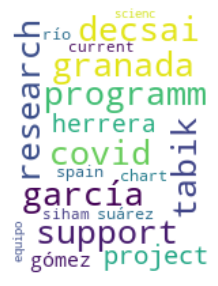

In [38]:
#wordcloud for top 5 words
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph8.png')

In [39]:
# Cosine similarity for top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_covid_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_covid_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled9.png')

cosine-similarity
           support      2020   granada     covid  programm
support          1  0.524928  0.955931 -0.115612         1
2020      0.524928         1  0.751685  0.784751  0.524928
granada   0.955931  0.751685         1  0.181107  0.955931
covid    -0.115612  0.784751  0.181107         1 -0.115612
programm         1  0.524928  0.955931 -0.115612         1


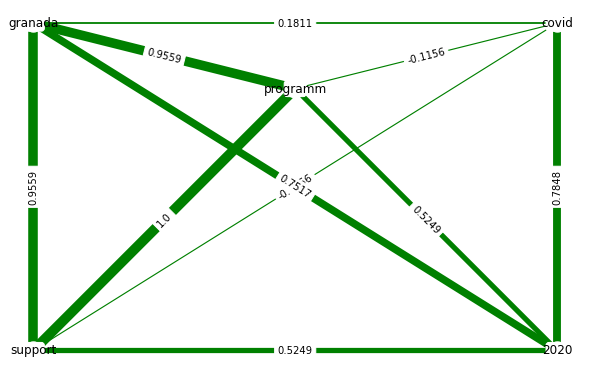

In [40]:
# networkx graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig9.png')

### LSA on covid-non-science-small.txt at 2-3 paragraph level

In [41]:
#loading data
document_list,titles,word_count_nscience=load_data("","covid-non-science-small.txt")

Number of words in text file : 5231
Total Number of Documents: 2


In [42]:
# data preprocessing/clenaing
clean_text=preprocess_data(document_list)

['covid', 'recovery', 'covid', 'reality', 'reuters', 'published', 'july', '2020', 'updated', 'july', '2020', 'marc', 'jones', 'london', 'july', 'reuters', 'world', 'shares', 'inched', 'towards', 'four', 'month', 'high', 'friday', 'industrial', 'bellwether', 'metal', 'copper', 'longest', 'weekly', 'winning', 'streak', 'nearly', 'three', 'years', 'recovering', 'global', 'data', 'kept', 'nagging', 'coronavirus', 'nerves', 'market', 'rally', 'fuelled', 'record', 'jobs', 'numbers', 'largely', 'blown', 'itself', 'amid', 'spike', 'covid', 'cases', 'though', 'fastest', 'expansion', 'china', 'services', 'sector', 'over', 'decade', 'more', 'stimulus', 'ensured', 'optimism', 'remained', 'chinese', 'shares', 'charged', 'their', 'highest', 'level', 'five', 'years', 'helping', 'asian', 'indexes', 'month', 'peaks', 'sight', 'european', 'markets', 'stalling', 'early', 'took', 'some', 'traders', 'surprise', 'currency', 'commodity', 'markets', 'also', 'subdued', 'feel', 'after', 'otherwise', 'strong', '

In [43]:
# LSA Model
number_of_topics=2
words=word_count_nscience
model_nscience=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_non_science =dict(model_nscience.show_topic(0, topn=words))##dict and encoding matrix values

In [44]:
#dictionary of top 5 words
dict(model_nscience.show_topic(0, topn=5))

{'market': 0.2643530403063791,
 'rate': 0.1875484784084695,
 'juli': 0.1791266417580849,
 'covid': 0.1791266417580845,
 'june': 0.1704527970965883}

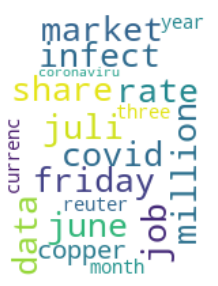

In [45]:
#wordcloud of top 5 words
from wordcloud import WordCloud
text = dict(model_nscience.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph9.png')

In [46]:
# Cosine similarity matrix of top 5 words
a=pd.DataFrame()

for i in range(number_of_topics):
    words_covid_non_science =dict(model_nscience.show_topic(i, topn=words))
    b=pd.DataFrame(words_covid_non_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_nscience.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled10.png')

cosine-similarity
          market      rate      juli     covid      june
market         1  0.711061  0.771166  0.771166  0.459512
rate    0.711061         1   0.10071   0.10071  0.951241
juli    0.771166   0.10071         1         1  -0.21108
covid   0.771166   0.10071         1         1  -0.21108
june    0.459512  0.951241  -0.21108  -0.21108         1


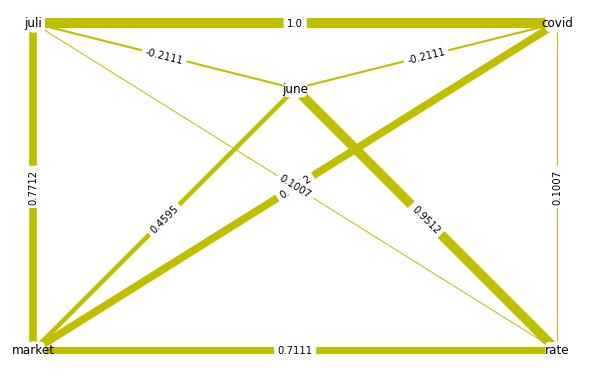

In [47]:
#networkx graph of top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='y',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig10.png')

### LSA on covid-psychology-small.txt at 2-3 paragraph level

In [48]:
#loading data
document_list,titles,word_count_psy=load_data("","covid-psychology-small.txt")

Number of words in text file : 39735
Total Number of Documents: 2


In [49]:
#data preprocessing/cleaning
clean_text=preprocess_data(document_list)

['international', 'sociology', '2021', 'author', '2020', 'article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissions', '1177', '0268580920948807', 'journals', 'sagepub', 'home', 'psychology', 'politics', 'covid', 'misinfodemics', 'people', 'believe', 'misinfodemics', 'sonia', 'mukhtar', 'university', 'management', 'technology', 'lahore', 'pakistan', 'abstract', 'misinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adverse', 'health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate', 'evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects', 'misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier', 'about', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'reviewed', 'this', 'a

In [50]:
# LSA Model
number_of_topics=2
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [51]:
#top 5 words from documents
dict(model_psy.show_topic(0, topn=5))

{'misinfodem': 0.4936266655941649,
 'covid': 0.3571916107745936,
 'articl': 0.21002057347124484,
 'commun': 0.14717103730334816,
 'health': 0.1471710373033479}

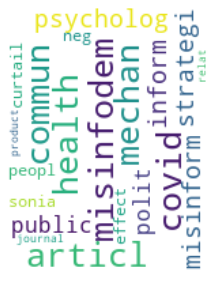

In [52]:
#wordcloud of top 5 words
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph28.png')

In [53]:
# Cosine similarity matrix of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psychology =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psychology,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled11.png')

cosine-similarity
           misinfodem     covid    articl    commun    health
misinfodem          1  0.977431  0.994116  0.761706  0.761706
covid        0.977431         1  0.948797  0.881393  0.881393
articl       0.994116  0.948797         1  0.687043  0.687043
commun       0.761706  0.881393  0.687043         1         1
health       0.761706  0.881393  0.687043         1         1


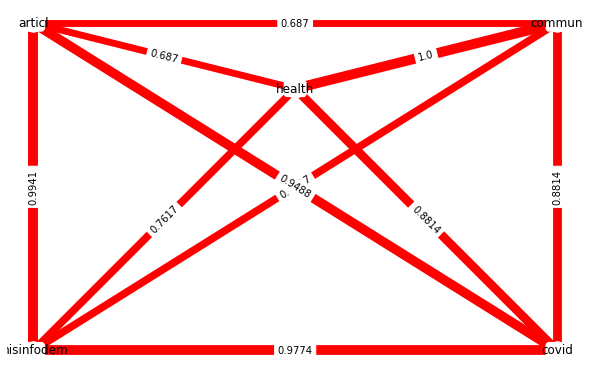

In [54]:
#NetworkX graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig11.png')

In [55]:
#mantel test for 10 word network
mantel_test(5)

Pairwise-distance
           misinfodem     covid    articl commun health   support      2020  \
misinfodem          0         0         0      0      0         0         0   
covid               0         0  0.360337      0      0  0.608033  0.282616   
articl              0  0.360337         0      0      0  0.404283  0.208896   
commun              0         0         0      0      0         0         0   
health              0         0         0      0      0         0         0   
support             0  0.608033  0.404283      0      0         0  0.327071   
2020                0  0.282616  0.208896      0      0  0.327071         0   
granada             0  0.457677  0.252649      0      0  0.161988  0.175514   
programm            0  0.526543  0.280864      0      0  0.126325  0.246469   

              granada   programm  
misinfodem          0          0  
covid        0.457677   0.526543  
articl       0.252649   0.280864  
commun              0          0  
health          

(-0.2789157231857564, 0.87744, -1.1428059907158423)

In [56]:
#mantel test for 20 word network
mantel_test(10)

Pairwise-distance
           misinfodem     covid    articl commun health mechan psycholog  \
misinfodem          0         0         0      0      0      0         0   
covid               0         0  0.360337      0      0      0         0   
articl              0  0.360337         0      0      0      0         0   
commun              0         0         0      0      0      0         0   
health              0         0         0      0      0      0         0   
mechan              0         0         0      0      0      0         0   
psycholog           0         0         0      0      0      0         0   
strategi            0         0         0      0      0      0         0   
misinform           0         0         0      0      0      0         0   
inform              0         0         0      0      0      0         0   
support             0  0.608033  0.404283      0      0      0         0   
2020                0  0.282616  0.208896      0      0      0        

(-0.16544931052577935, 0.87239, -1.119178592676496)

In [57]:
mantel_test_n(5)

Pairwise-distance
         market rate juli     covid june   support      2020    granada  \
market        0    0    0         0    0         0         0          0   
rate          0    0    0         0    0         0         0          0   
juli          0    0    0         0    0         0         0          0   
covid         0    0    0         0    0  0.608033  0.282616   0.457677   
june          0    0    0         0    0         0         0          0   
support       0    0    0  0.608033    0         0  0.327071   0.161988   
2020          0    0    0  0.282616    0  0.327071         0   0.175514   
granada       0    0    0  0.457677    0  0.161988  0.175514          0   
programm      0    0    0  0.526543    0  0.126325  0.246469  0.0742376   

           programm  
market            0  
rate              0  
juli              0  
covid      0.526543  
june              0  
support    0.126325  
2020       0.246469  
granada   0.0742376  
programm          0  
Pairwise-di

(-0.32116363224774647, 0.97195, -1.4419752809078545)

In [58]:
mantel_test_n(10)

Pairwise-distance
         market rate juli     covid june friday also infect job million  \
market        0    0    0         0    0      0    0      0   0       0   
rate          0    0    0         0    0      0    0      0   0       0   
juli          0    0    0         0    0      0    0      0   0       0   
covid         0    0    0         0    0      0    0      0   0       0   
june          0    0    0         0    0      0    0      0   0       0   
friday        0    0    0         0    0      0    0      0   0       0   
also          0    0    0         0    0      0    0      0   0       0   
infect        0    0    0         0    0      0    0      0   0       0   
job           0    0    0         0    0      0    0      0   0       0   
million       0    0    0         0    0      0    0      0   0       0   
support       0    0    0  0.608033    0      0    0      0   0       0   
2020          0    0    0  0.282616    0      0    0      0   0       0   
granada

(-0.245133288012048, 0.9991, -1.8229540903621335)

## Paragraph level

### LSA oncovid-science-small.txt at paragraph level

In [59]:
#data loading
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r",encoding='UTF8') as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            if text !='':
                documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [60]:
document_list,titles,word_count_science=load_data("","covid-science-small.txt")

Number of words in text file : 59691
Total Number of Documents: 7401


In [61]:
#data preprocessing
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet']
['methodology', 'predicting', 'covid']
['based', 'chest', 'images']
['tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte']
['guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova']
['olmedo', 'sánchez', 'herrera']
['abstract', 'currently', 'coronavirus', 'disease', 'covid']
['most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans']
['chest', 'images', 'computed', 'tomography']
['scanners', 'testing', 'available', 'most']
['medical', 'centers', 'hence', 'many', 'cases', 'images']
['become', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networks']
['have', 'great', 'potential', 'building', 'covid', 'triage', 'systems']
['detecting', 'covid', 'patients', 'especially', 'patients', 'with']
['severity', 'unfortunately', 'current', 'databases', 'allow']
['building', 'such', 'systems'

In [62]:
# LSA Model
number_of_topics=100
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_law =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [63]:
#dictionary of top 5 words
dict(model_science.show_topic(0, topn=5))

{'covid': 0.73821652382471,
 'model': 0.31135069890134603,
 'imag': 0.27205525106833406,
 'use': 0.19292326348390718,
 'detect': 0.1541950342665124}

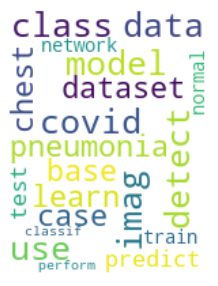

In [64]:
#wordcloud for top 10 words
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph10.png')

In [65]:
# cosine similarity matrix for top 5 words
a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled12.png')

cosine-similarity
              covid        model         imag          use      detect
covid             1  0.000452072      0.00159  0.000898663   0.0115803
model   0.000452072            1   0.00101501  8.90285e-05  0.00275819
imag        0.00159   0.00101501            1 -0.000360897 -0.00105903
use     0.000898663  8.90285e-05 -0.000360897            1  0.00238728
detect    0.0115803   0.00275819  -0.00105903   0.00238728           1


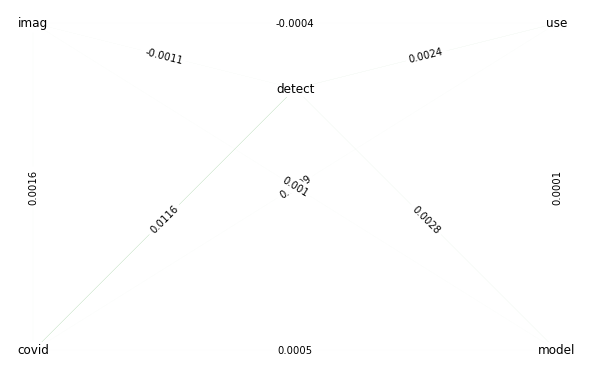

In [66]:
#Networkx graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig12.png')

### LSA on covid-non-science-small.txt at paragraph level

In [67]:
#loading dataset
document_list,titles,word_count_nscience=load_data("","covid-non-science-small.txt")

Number of words in text file : 5231
Total Number of Documents: 229


In [68]:
#cleaning documents
clean_text=preprocess_data(document_list)

['covid', 'recovery', 'covid', 'reality']
['reuters']
['published', 'july', '2020', 'updated', 'july', '2020']
['marc', 'jones']
['london', 'july', 'reuters', 'world', 'shares', 'inched', 'towards', 'four', 'month', 'high', 'friday', 'industrial', 'bellwether', 'metal', 'copper', 'longest', 'weekly', 'winning', 'streak', 'nearly', 'three', 'years', 'recovering', 'global', 'data', 'kept', 'nagging', 'coronavirus', 'nerves']
['market', 'rally', 'fuelled', 'record', 'jobs', 'numbers', 'largely', 'blown', 'itself', 'amid', 'spike', 'covid', 'cases', 'though', 'fastest', 'expansion', 'china', 'services', 'sector', 'over', 'decade', 'more', 'stimulus', 'ensured', 'optimism', 'remained']
['chinese', 'shares', 'charged', 'their', 'highest', 'level', 'five', 'years', 'helping', 'asian', 'indexes', 'month', 'peaks', 'sight', 'european', 'markets', 'stalling', 'early', 'took', 'some', 'traders', 'surprise']
['currency', 'commodity', 'markets', 'also', 'subdued', 'feel', 'after', 'otherwise', 'str

In [69]:
# LSA Model
number_of_topics=100
words=word_count_nscience
model_nscience=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_non_science =dict(model_nscience.show_topic(0, topn=words))##dict and encoding matrix values

In [70]:
#dictionary of top 5 words
dict(model_nscience.show_topic(0, topn=5))

{'trial': -0.4357698515176407,
 'vaccin': -0.3522508419172812,
 'stage': -0.3104392334067969,
 'late': -0.27993679585081893,
 'expect': -0.2175291307730242}

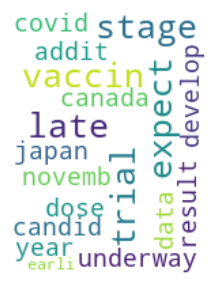

In [71]:
#wordcloud for top 10 words
from wordcloud import WordCloud
text = dict(model_nscience.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph11.png')

In [72]:
# Cosinesimilarity matrix of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_non_science =dict(model_nscience.show_topic(i, topn=words))
    b=pd.DataFrame(words_non_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_nscience.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled13.png')

cosine-similarity
           trial    vaccin     stage      late    expect
trial          1  0.126472  0.861164  0.709278  0.825116
vaccin  0.126472         1  0.179982  0.149438  0.162041
stage   0.861164  0.179982         1  0.838425  0.944611
late    0.709278  0.149438  0.838425         1  0.791853
expect  0.825116  0.162041  0.944611  0.791853         1


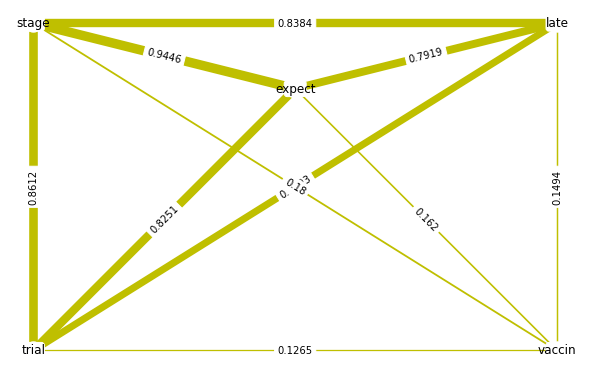

In [73]:
#networkx graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='y',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig13.png')

### LSA on covid-psychology-small.txt at paragraph level

In [74]:
#loading dataset
document_list,titles,word_count_psy=load_data("","covid-psychology-small.txt")

Number of words in text file : 39735
Total Number of Documents: 4481


In [75]:
#data preprocessing
clean_text=preprocess_data(document_list)

['international', 'sociology']
['2021']
['author', '2020']
['article', 'reuse', 'guidelines']
['sagepub', 'journals', 'permissions']
['1177', '0268580920948807']
['journals', 'sagepub', 'home']
['psychology', 'politics']
['covid', 'misinfodemics']
['people']
['believe', 'misinfodemics']
['sonia', 'mukhtar']
['university', 'management', 'technology', 'lahore', 'pakistan']
['abstract']
['misinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adverse']
['health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate']
['evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects']
['misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier']
['about', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'rev

In [76]:
# LSA Model
number_of_topics=100
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [77]:
#dictionary of top 5 words
dict(model_psy.show_topic(0, topn=5))

{'pandem': 0.3326166193080187,
 'polici': 0.3139495133883562,
 'health': 0.27521477458171695,
 'covid': 0.2512038811196319,
 'impact': 0.23725655752332728}

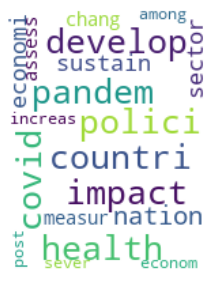

In [78]:
#wordcloud for top 5 words
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph29.png')

In [79]:
# cosine similarity matrix for top 5 words
a=pd.DataFrame()

for i in range(number_of_topics):
    words_psychology =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psychology,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled14.png')

cosine-similarity
             pandem      polici       health        covid       impact
pandem            1 -0.00470168  -0.00359301  0.000337034   0.00558144
polici  -0.00470168           1      0.02514  -0.00434368  -0.00157005
health  -0.00359301     0.02514            1  -0.00213173  0.000864294
covid   0.000337034 -0.00434368  -0.00213173            1   0.00554273
impact   0.00558144 -0.00157005  0.000864294   0.00554273            1


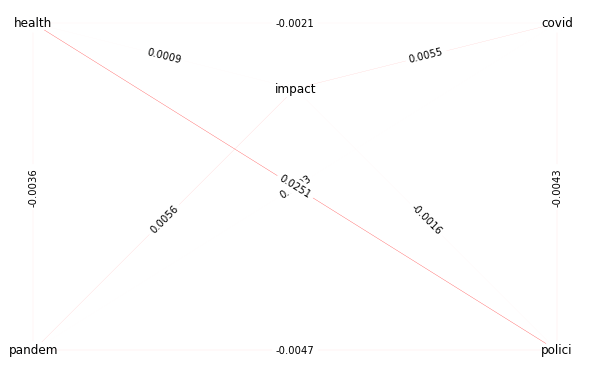

In [80]:
#networkx graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig14.png')

In [81]:
mantel_test(5)

Pairwise-distance
          pandem       polici    health     covid       impact    model  \
pandem         0     0.805036   1.01123   1.25503     0.809695  1.27776   
polici  0.805036  9.31323e-10  0.722102  0.992408     0.158666   0.9948   
health   1.01123     0.722102         0   1.24213     0.650069  1.23484   
covid    1.25503     0.992408   1.24213         0     0.993882  1.40107   
impact  0.809695     0.158666  0.650069  0.993882  5.26836e-09  1.00463   
model    1.27776       0.9948   1.23484   1.40107      1.00463        0   
imag     1.28264     0.990826   1.23416     1.398      1.00471  1.39962   
use      1.27322     0.991493   1.23268   1.40142      1.00621   1.4032   
detect   1.25514     0.961398   1.19357   1.36915     0.959384  1.37647   

               imag       use    detect  
pandem      1.28264   1.27322   1.25514  
polici     0.990826  0.991493  0.961398  
health      1.23416   1.23268   1.19357  
covid         1.398   1.40142   1.36915  
impact      1.00471  

(-0.36044591617335736, 0.83188, -1.077892663878568)

In [82]:
mantel_test(10)

Pairwise-distance
             pandem       polici    health     covid       impact      2020  \
pandem            0     0.805036   1.01123   1.25503     0.809695   1.22311   
polici     0.805036  9.31323e-10  0.722102  0.992408     0.158666  0.930378   
health      1.01123     0.722102         0   1.24213     0.650069   1.18737   
covid       1.25503     0.992408   1.24213         0     0.993882    1.3589   
impact     0.809695     0.158666  0.650069  0.993882  5.26836e-09  0.948735   
2020        1.22311     0.930378   1.18737    1.3589     0.948735         0   
develop    0.857162     0.282271  0.772437   1.02832     0.288594  0.977722   
countri     0.78996    0.0978683  0.731875  0.997722     0.176283  0.935336   
nation     0.959555     0.502134  0.801066   1.10818     0.484074   1.06107   
sustain    0.802517     0.059464  0.735623   0.99013     0.151684  0.927968   
model       1.27776       0.9948   1.23484   1.40107      1.00463   1.35636   
imag        1.28264     0.990826  

(-0.46950690647912063, 0.98796, -2.1198161571850607)

In [83]:
mantel_test_n(5)

Pairwise-distance
              trial       vaccin        stage         late       expect  \
trial   2.32831e-10    0.0321631     0.116023    0.0315024     0.106246   
vaccin    0.0321631  6.58545e-10     0.122716    0.0424287     0.113222   
stage      0.116023     0.122716  1.86265e-09      0.11955     0.154401   
late      0.0315024    0.0424287      0.11955  4.65661e-10     0.114867   
expect     0.106246     0.113222     0.154401     0.114867  3.72529e-09   
covid      0.990182     0.990235     0.992167     0.992115     0.993154   
model      0.991998     0.992868     0.999485     0.992032     0.994909   
imag       0.988698     0.989315      0.99235     0.989705     0.999658   
use        0.992879     0.994046     0.993865     0.993597     0.998827   
detect     0.957615     0.950483     0.968579     0.957712     0.970974   

           covid     model         imag       use    detect  
trial   0.990182  0.991998     0.988698  0.992879  0.957615  
vaccin  0.990235  0.992868     0

(-0.00835086488115451, 0.52709, -0.02417688171174474)

In [84]:
mantel_test_n(10)

Pairwise-distance
                 trial       vaccin        stage         late       expect  \
trial      2.32831e-10    0.0321631     0.116023    0.0315024     0.106246   
vaccin       0.0321631  6.58545e-10     0.122716    0.0424287     0.113222   
stage         0.116023     0.122716  1.86265e-09      0.11955     0.154401   
late         0.0315024    0.0424287      0.11955  4.65661e-10     0.114867   
expect        0.106246     0.113222     0.154401     0.114867  3.72529e-09   
underway             0            0            0            0            0   
dose                 0            0            0            0            0   
novemb       0.0510105    0.0598232     0.128761    0.0526716     0.123767   
addit         0.129501     0.130605     0.177833     0.128789     0.151949   
develop       0.275278     0.264194     0.308447     0.274625     0.294212   
covid         0.990182     0.990235     0.992167     0.992115     0.993154   
model         0.991998     0.992868     0.9994

(-0.16970638044077413, 0.79436, -0.8424665192300715)